In [ ]:
# taken from https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
# but check this too: https://pytorch.org/vision/stable/models.html
# class names for ImageNet are here: https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57
# download flowers from https://dataverse.harvard.edu/file.xhtml?fileId=4105627&version=8.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/cnn

Mounted at /content/drive


## task for retraining last layer

In [ ]:
from torchvision import models
import torchvision
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

def load_data(data_type):
  if data_type not in ['train', 'validation', 'test']:
    raise ValueError('check data type name')
  DATA_PATH = f"flowers/flower_photos/{data_type}"
  data = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=transform)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  loader = torch.utils.data.DataLoader(data,batch_size=4,shuffle=True,num_workers=4)

  return data, loader

def freeze_alexnet(layers_number):
  alexnet = models.alexnet(pretrained=True)
  for c in alexnet.children():
      for param in c.parameters():
          param.requires_grad = False #freezing all layers

  num_classes = len(train_data.classes)
  alexnet.classifier[6] = torch.nn.Linear(4096, num_classes)
  alexnet.classifier[-layers_number:].requires_grad = True # unfreezing some at the end
  return alexnet

def train_alexnet(model):
  alexnet_last = []
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          alexnet_last.append(param)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(alexnet_last, lr=0.001, betas=(0.9, 0.999)) 
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  alexnet = model.to(device)
  alexnet.train()
  for epoch in tqdm(range(20)):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      print(f'epoch: {epoch + 1} loss: {running_loss}')
      running_loss = 0.0
  print('Finished Training')


train_data, train_loader = load_data('train')
valid_data, valid_loader = load_data('validation')
test_data, test_loader = load_data('test')

alexnet_freeze_1layer = freeze_alexnet(1)
alexnet_freeze_2layer = freeze_alexnet(3)
alexnet_freeze_3layer = freeze_alexnet(6)

print(alexnet_freeze_3layer)

train_alexnet(alexnet_freeze_1layer)
train_alexnet(alexnet_freeze_2layer)
train_alexnet(alexnet_freeze_3layer)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

  5%|▌         | 1/20 [00:21<06:40, 21.09s/it]

epoch: 1 loss: 594.4771458992126


 10%|█         | 2/20 [00:43<06:36, 22.00s/it]

epoch: 2 loss: 359.35698146414916


 15%|█▌        | 3/20 [01:04<06:03, 21.36s/it]

epoch: 3 loss: 255.3349473538136


 20%|██        | 4/20 [01:24<05:36, 21.00s/it]

epoch: 4 loss: 262.09667637142843


 25%|██▌       | 5/20 [01:47<05:21, 21.45s/it]

epoch: 5 loss: 236.73709304607377


 30%|███       | 6/20 [02:07<04:56, 21.14s/it]

epoch: 6 loss: 206.19853075339648


 35%|███▌      | 7/20 [02:28<04:35, 21.21s/it]

epoch: 7 loss: 210.67571609215938


 40%|████      | 8/20 [02:52<04:22, 21.85s/it]

epoch: 8 loss: 177.4303150522218


 45%|████▌     | 9/20 [03:13<03:58, 21.68s/it]

epoch: 9 loss: 195.63985298781526


 50%|█████     | 10/20 [03:34<03:33, 21.34s/it]

epoch: 10 loss: 192.943722029432


 55%|█████▌    | 11/20 [03:54<03:10, 21.13s/it]

epoch: 11 loss: 175.0485241161922


 60%|██████    | 12/20 [04:15<02:47, 20.99s/it]

epoch: 12 loss: 195.78044049418872


 65%|██████▌   | 13/20 [04:35<02:26, 20.89s/it]

epoch: 13 loss: 160.74518263216248


 70%|███████   | 14/20 [04:56<02:05, 20.92s/it]

epoch: 14 loss: 183.90772021857532


 75%|███████▌  | 15/20 [05:17<01:44, 20.86s/it]

epoch: 15 loss: 177.3902128205043


 80%|████████  | 16/20 [05:38<01:23, 20.79s/it]

epoch: 16 loss: 119.9331869168398


 85%|████████▌ | 17/20 [05:59<01:02, 20.79s/it]

epoch: 17 loss: 162.4654318611671


 90%|█████████ | 18/20 [06:19<00:41, 20.77s/it]

epoch: 18 loss: 180.20479510357453


 95%|█████████▌| 19/20 [06:40<00:20, 20.76s/it]

epoch: 19 loss: 175.0437898445888


100%|██████████| 20/20 [07:02<00:00, 21.14s/it]


epoch: 20 loss: 146.17647410369253
Finished Training


  5%|▌         | 1/20 [00:20<06:32, 20.68s/it]

epoch: 1 loss: 607.1123587907077


 10%|█         | 2/20 [00:41<06:14, 20.78s/it]

epoch: 2 loss: 362.8892165960614


 15%|█▌        | 3/20 [01:02<05:53, 20.79s/it]

epoch: 3 loss: 299.5852547862017


 20%|██        | 4/20 [01:22<05:31, 20.69s/it]

epoch: 4 loss: 251.26811540572865


 25%|██▌       | 5/20 [01:43<05:10, 20.70s/it]

epoch: 5 loss: 259.57144942251585


 30%|███       | 6/20 [02:04<04:50, 20.75s/it]

epoch: 6 loss: 249.59880502856828


 35%|███▌      | 7/20 [02:25<04:29, 20.73s/it]

epoch: 7 loss: 210.21946643144767


 40%|████      | 8/20 [02:45<04:08, 20.70s/it]

epoch: 8 loss: 244.14151164535238


 45%|████▌     | 9/20 [03:06<03:47, 20.67s/it]

epoch: 9 loss: 162.53664639068222


 50%|█████     | 10/20 [03:27<03:26, 20.68s/it]

epoch: 10 loss: 174.313760387426


 55%|█████▌    | 11/20 [03:47<03:05, 20.67s/it]

epoch: 11 loss: 195.13523225121378


 60%|██████    | 12/20 [04:08<02:45, 20.68s/it]

epoch: 12 loss: 185.18039651447407


 65%|██████▌   | 13/20 [04:28<02:24, 20.63s/it]

epoch: 13 loss: 177.1082989072777


 70%|███████   | 14/20 [04:49<02:03, 20.57s/it]

epoch: 14 loss: 134.9746241411752


 75%|███████▌  | 15/20 [05:09<01:42, 20.56s/it]

epoch: 15 loss: 174.59563734834538


 80%|████████  | 16/20 [05:30<01:22, 20.55s/it]

epoch: 16 loss: 167.44621783289486


 85%|████████▌ | 17/20 [05:51<01:01, 20.57s/it]

epoch: 17 loss: 163.20888801492595


 90%|█████████ | 18/20 [06:11<00:41, 20.58s/it]

epoch: 18 loss: 157.18433748980678


 95%|█████████▌| 19/20 [06:32<00:20, 20.59s/it]

epoch: 19 loss: 162.60256524837624


100%|██████████| 20/20 [06:52<00:00, 20.65s/it]


epoch: 20 loss: 156.21706208694224
Finished Training


  5%|▌         | 1/20 [00:20<06:33, 20.70s/it]

epoch: 1 loss: 594.6242871207726


 10%|█         | 2/20 [00:41<06:11, 20.64s/it]

epoch: 2 loss: 378.0944154440034


 15%|█▌        | 3/20 [01:01<05:51, 20.65s/it]

epoch: 3 loss: 273.87436933135


 20%|██        | 4/20 [01:22<05:30, 20.65s/it]

epoch: 4 loss: 259.0457983632906


 25%|██▌       | 5/20 [01:43<05:09, 20.64s/it]

epoch: 5 loss: 208.24203191257482


 30%|███       | 6/20 [02:04<04:49, 20.69s/it]

epoch: 6 loss: 229.44776314053848


 35%|███▌      | 7/20 [02:24<04:29, 20.73s/it]

epoch: 7 loss: 240.32447574313684


 40%|████      | 8/20 [02:45<04:08, 20.74s/it]

epoch: 8 loss: 209.52382112147558


 45%|████▌     | 9/20 [03:06<03:47, 20.71s/it]

epoch: 9 loss: 199.31323836231775


 50%|█████     | 10/20 [03:26<03:27, 20.72s/it]

epoch: 10 loss: 215.60592360247472


 55%|█████▌    | 11/20 [03:47<03:06, 20.72s/it]

epoch: 11 loss: 173.97308725482128


 60%|██████    | 12/20 [04:08<02:45, 20.75s/it]

epoch: 12 loss: 175.99920773507796


 65%|██████▌   | 13/20 [04:29<02:25, 20.73s/it]

epoch: 13 loss: 171.21722529158794


 70%|███████   | 14/20 [04:50<02:04, 20.78s/it]

epoch: 14 loss: 193.02810336906919


 75%|███████▌  | 15/20 [05:10<01:43, 20.79s/it]

epoch: 15 loss: 185.2627309557025


 80%|████████  | 16/20 [05:31<01:23, 20.78s/it]

epoch: 16 loss: 134.75225187429868


 85%|████████▌ | 17/20 [05:52<01:02, 20.80s/it]

epoch: 17 loss: 196.55646244485905


 90%|█████████ | 18/20 [06:13<00:41, 20.81s/it]

epoch: 18 loss: 175.86956597087544


 95%|█████████▌| 19/20 [06:34<00:20, 20.79s/it]

epoch: 19 loss: 164.34306981014728


100%|██████████| 20/20 [06:54<00:00, 20.74s/it]

epoch: 20 loss: 170.33748783918827
Finished Training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

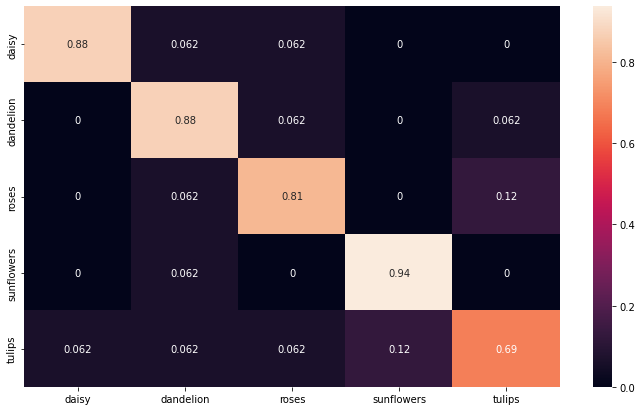

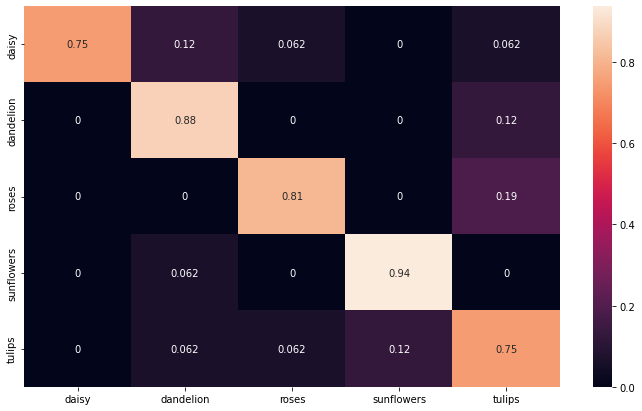

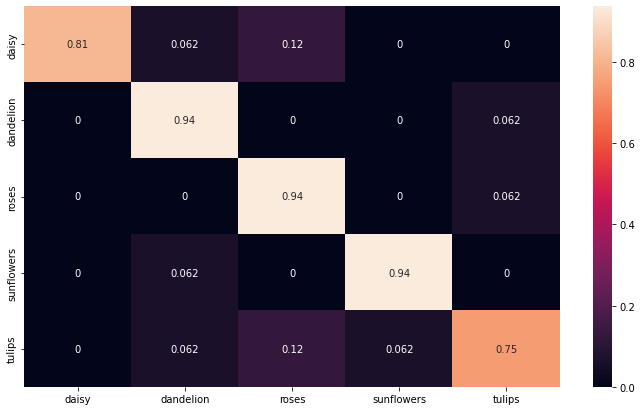

In [ ]:
def show_confusion_matrix_model(model, loader):
  y_pred, y_true = [], []
  model.eval()
  alexnet = model.to('cpu')
  for inputs, labels in loader:
          output = alexnet(inputs) 
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) 
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) 
  classes = train_data.classes

  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*len(classes), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)


show_confusion_matrix_model(alexnet_freeze_1layer, valid_loader)
show_confusion_matrix_model(alexnet_freeze_2layer, valid_loader)
show_confusion_matrix_model(alexnet_freeze_3layer, valid_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


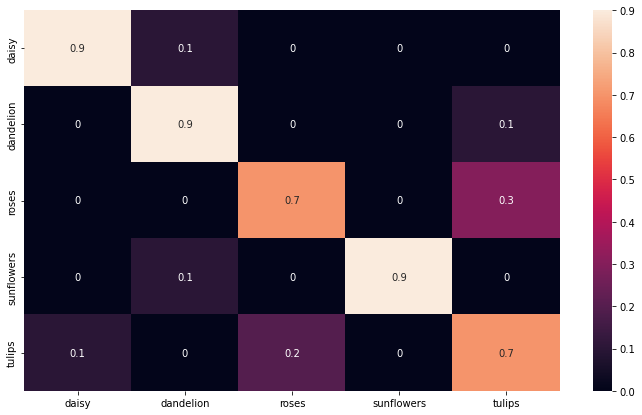

In [ ]:
show_confusion_matrix_model(alexnet_freeze_3layer, test_loader)